In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import sys

In [9]:
# Standard setup is two players with one six-sided die each
# Don't actually change the player count. The rest of the program is hardcoded to use two players
PLAYERS = 2
# Each training iteration takes exponentially longer when DICE_PER_PLAYER or SIDES_PER_DIE is increased
DICE_PER_PLAYER = 1
SIDES_PER_DIE = 6
NUM_ACTIONS = PLAYERS * DICE_PER_PLAYER * SIDES_PER_DIE + 1
DUDO_ACTION = NUM_ACTIONS - 1
# How many moves the model remembers.
# This is an abstraction to reduce the number of possible history variations and the history stops mattering beyond a certain point
HISTORY_RECALL = 3

def translate_action_to_claim(action):
    if action == DUDO_ACTION:
        return "Dudo"
    claim_amount = int(np.ceil((1 + action) / SIDES_PER_DIE))
    claim_rank = 1 + (1 + action) % SIDES_PER_DIE
    return claim_amount, claim_rank

In [3]:
class Node():
    def __init__(self, rolls, history, num_actions):
        self.rolls = rolls
        self.history = history
        self.num_actions = num_actions
        self.regret_sum = np.zeros(num_actions)
        self.strategy_sum = np.zeros(num_actions)

    def __repr__(self):
        history = str([translate_action_to_claim(h) for h in self.history])
        strategy = self.normalize(self.strategy_sum)
        return str(self.rolls) + history + str(strategy)

    def normalize(self, value):
        normalizing_sum = np.sum(value)
        if normalizing_sum > 0:
            return value / normalizing_sum
        return np.ones(self.num_actions) / self.num_actions

    def get_strategy(self):
        return self.normalize(np.maximum(self.regret_sum, 0))

    def get_action(self):
        strategy = self.normalize(self.strategy_sum)
        return np.searchsorted(np.cumsum(strategy), np.random.random())

In [16]:
def get_terminal_payout(history, rolls):
    claim_amount, claim_rank = translate_action_to_claim(history[-2])
    real_amount = np.count_nonzero((rolls == claim_rank) | (rolls == 1))
    return 1 if real_amount >= claim_amount else -1

def get_node(nodes, history, player_roll) -> Node:
    actions_without_dudo = NUM_ACTIONS-1
    actions_stronger_than_previous = NUM_ACTIONS - history[-1] - 1
    valid_actions = actions_without_dudo if len(history) == 0 else actions_stronger_than_previous
    info_set_hash = str(player_roll) + str(history)

    node = nodes.get(info_set_hash, Node(player_roll, history, valid_actions))
    nodes[info_set_hash] = node
    return node

def counter_factual_regret(nodes, player, rolls, history, realization_weight_p0, realization_weight_p1):
    opponent = (player + 1) % 2
    player0_turn = player == 0

    if len(history) > 0 and history[-1] == DUDO_ACTION:
        return get_terminal_payout(history, rolls)

    node = get_node(nodes, history, rolls[player])
    strategy = node.get_strategy()
    node.strategy_sum += strategy * (realization_weight_p0 if player0_turn else realization_weight_p1)
    
    utility = np.zeros(node.num_actions)
    node_utility = 0

    invalid_actions = NUM_ACTIONS - node.num_actions if len(history) > 0 else 0
    for action in range(invalid_actions, invalid_actions + min(node.num_actions, DUDO_ACTION)):
        next_history = np.append(history[max(len(history)-HISTORY_RECALL+1, 0):], action)
        action_index = action - invalid_actions
        
        p0_weight = realization_weight_p0 if not player0_turn else strategy[action] * realization_weight_p0
        p1_weight = realization_weight_p1 if player0_turn else strategy[action] * realization_weight_p1
        utility[action_index] = -counter_factual_regret(nodes, opponent, rolls, next_history, p0_weight, p1_weight)
        node_utility += strategy[action_index] * utility[action_index]

    node.regret_sum += (utility - node_utility) * (realization_weight_p1 if player0_turn else realization_weight_p0)
    return node_utility

def train(iterations):
    nodes = {}

    utility = 0
    for _ in trange(iterations):
        rolls = np.random.randint(1, SIDES_PER_DIE+1, (PLAYERS, DICE_PER_PLAYER))
        utility += counter_factual_regret(nodes, 0, rolls, np.array([], dtype=int), 1, 1)

    print("Average game value:", utility / iterations)
    print("Theoretical nash equilibrium average game value:", -7/258)

    LOG_NODE_PROBABILITIES = False
    if LOG_NODE_PROBABILITIES:
        nodes_values = dict(sorted(nodes.items(), key=lambda item: item[0]))
        for n in nodes_values.values():
            print(n)
    return nodes

In [10]:
nodes = train(200)

100%|██████████| 200/200 [01:12<00:00,  2.74it/s]

Average game value: -0.05663820148933768
Theoretical nash equilibrium average game value: -0.027131782945736434


Mean score: 0.72 Median score: 0.0


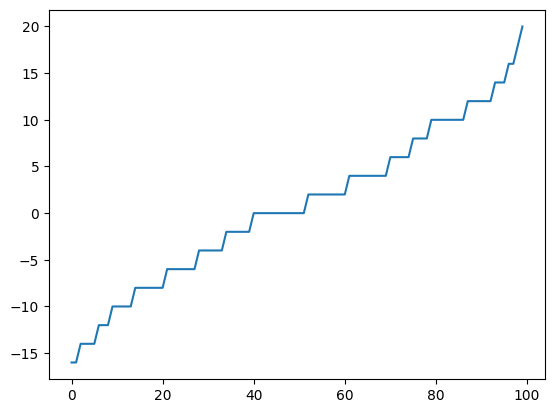

In [6]:
# trained model playing against itself
games = []

for j in range(100):
    game_scores = 0
    player = 0
    for i in range(100):
        history = np.array([], dtype=int)
        rolls = np.random.randint(1, SIDES_PER_DIE+1, (PLAYERS, DICE_PER_PLAYER))
        while True:
            valid_action_count = NUM_ACTIONS if len(history) == 0 else NUM_ACTIONS - history[-1] - 1
            invalid_actions = NUM_ACTIONS - valid_action_count
            node = get_node(nodes, history, rolls[player])
            action = invalid_actions + node.get_action()
            history = np.append(history[max(len(history)-HISTORY_RECALL+1, 0):], action)

            if action == DUDO_ACTION:
                win_payoff = 1 if player == 1 else -1
                if get_terminal_payout(history, rolls) == win_payoff:
                    game_scores += 1
                else:
                    game_scores -= 1
                break
            player = 1 - player
    games.append(game_scores)

# No suprise, the average score when playing against itself is close to 0, i.e. it is not better than itself
plt.plot(sorted(games))
print("Mean score:", np.mean(games), "Median score:", np.median(games))

In [15]:
# play against the trained model
rolls = np.random.randint(1, SIDES_PER_DIE+1, (PLAYERS, DICE_PER_PLAYER))
print("You rolled", rolls[0])

player = np.random.randint(0, 2)
history = np.array([], dtype=int)

while True:
    valid_action_count = NUM_ACTIONS if len(history) == 0 else NUM_ACTIONS - history[-1] - 1
    invalid_actions = NUM_ACTIONS - valid_action_count
    if player == 0:
        valid_actions = np.arange(invalid_actions, invalid_actions + min(valid_action_count, DUDO_ACTION))
        valid_actions_text = [str(a) + ":" + str(translate_action_to_claim(a)) for a in valid_actions]
        print("Valid actions are:", valid_actions_text)
        sys.stdout.flush()
        
        string_action = input("Choose action")
        try:
            action = int(string_action)
        except:
            print("Action has to be a valid number", string_action)
            continue
        if action not in valid_actions:
            print("Invalid action:", int(action))
            continue
        print("You call:", translate_action_to_claim(action))

    else: # Sample action from model
        node = get_node(nodes, history, rolls[player])
        action = invalid_actions + node.get_action()
        print("Opponent calls:", translate_action_to_claim(action))

    history = np.append(history[max(len(history)-HISTORY_RECALL+1, 0):], action) 
    if action == DUDO_ACTION:
        win_payoff = 1 if player == 1 else -1
        print("Actual rolls:", rolls.tolist())
        if get_terminal_payout(history, rolls) == win_payoff:
            print("You win!")
        else:
            print("You lose!")
        break
    player = 1 - player

You rolled [2]
Valid actions are: ['0:(1, 2)', '1:(1, 3)', '2:(1, 4)', '3:(1, 5)', '4:(1, 6)', '5:(1, 1)', '6:(2, 2)', '7:(2, 3)', '8:(2, 4)', '9:(2, 5)', '10:(2, 6)', '11:(2, 1)']
You call: (1, 2)
Opponent calls: (2, 3)
Valid actions are: ['8:(2, 4)', '9:(2, 5)', '10:(2, 6)', '11:(2, 1)', '12:Dudo']
You call: Dudo
Actual rolls: [[2], [3]]
You win!
